In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
%matplotlib inline

In [2]:
# 데이터 파일 로딩
!curl -L https://goo.gl/s8qSL5  -o ./data/bike_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
curl: (35) schannel: next InitializeSecurityContext failed: SEC_E_UNTRUSTED_ROOT (0x80090325) - 신뢰되지 않은 기관에서 인증서 체인을 발급했습니다.


In [3]:
# Datatime을 date 형식으로 Parsing
train = pd.read_csv("data/bike_train.csv", parse_dates=["datetime"])
train.head().T

,0,1,2,3,4
datetime,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,2011-01-01 03:00:00,2011-01-01 04:00:00
season,1,1,1,1,1
holiday,0,0,0,0,0
workingday,0,0,0,0,0
weather,1,1,1,1,1
temp,9.84,9.02,9.02,9.84,9.84
atemp,14.395,13.635,13.635,14.395,14.395
humidity,81,80,80,75,75
windspeed,0,0,0,0,0
casual,3,8,5,3,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
# Date 데이터 분해

train["d-year"] = train["datetime"].dt.year
train["d-month"] = train["datetime"].dt.month
train["d-day"] = train["datetime"].dt.day
train["d-hour"] = train["datetime"].dt.hour
train["d-minute"] = train["datetime"].dt.minute
train["d-second"] = train["datetime"].dt.second

train[["datetime", "d-year", "d-month", "d-day", "d-hour", "d-minute", "d-second"]].head()

,datetime,d-year,d-month,d-day,d-hour,d-minute,d-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


In [7]:
# 요일 구분

train["d-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "d-dayofweek"]].head()

(10886, 19)


,datetime,d-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


## 연도와 월을 합한 특성 변수 생성

In [8]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["d-year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "d-year_month"]].head()

(10886, 20)


,datetime,d-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


## 훈련에 사용할 특성 선택

In [9]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-minute', 'd-second',
       'd-dayofweek', 'd-year_month'],
      dtype='object')

In [10]:
train.head().T

,0,1,2,3,4
datetime,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,2011-01-01 03:00:00,2011-01-01 04:00:00
season,1,1,1,1,1
holiday,0,0,0,0,0
workingday,0,0,0,0,0
weather,1,1,1,1,1
temp,9.84,9.02,9.02,9.84,9.84
atemp,14.395,13.635,13.635,14.395,14.395
humidity,81,80,80,75,75
windspeed,0,0,0,0,0
casual,3,8,5,3,0


In [11]:
# 11개 Features 정의
features_11 = ["season", "holiday", "workingday", "weather",            
             "temp", "atemp", "humidity", "windspeed",
                 "d-year", "d-hour", "d-dayofweek"]

# 13개 Features 정의
features_13 = ["season", "holiday", "workingday", "weather",            
            "temp", "atemp", "humidity", "windspeed", "casual", "registered",
                 "d-year", "d-hour", "d-dayofweek"]

In [12]:
X11 = train[features_11]
print(X11.shape)
X11.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,2011,4,5


In [13]:
y = train["count"]
print(y.shape)

(10886,)


In [14]:
## log를 씌우는 이유는 평가 결과 값의 편차를 상대적으로 줄이기 위해서. MAE vs MSE vs MSLE
## 평가 결과값이 클때 오차를 줄일 필요가 있으면 MSE
## 평가 결과값이 작을때의 오차를 줄일 필요가 있으면 MSLE

import numpy as np
y_log = np.log(y + 1) #y가 0열 경우에 오류를 방지하기 위함

print(y_log.shape)
y_log.head()

(10886,)


0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

## 예측 모델 개선

In [15]:
# 11개 Feature를 통해 Train, Test Data Split
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X11, y, test_size = 0.2)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X11, y_log, test_size = 0.2)

In [16]:
model = RandomForestRegressor(n_estimators= 100)
model.fit(X_train, y_train)
model1 = RandomForestRegressor(n_estimators= 100)
model1.fit(X_train1, y_train1)
print(f"Feature 11개 모델의 R스퀘어 값(결과값 y): {model.score(X_test, y_test):.5f}")
print(f"Feature 11개 모델의 R스퀘어 값(결과값 y_log): {model1.score(X_test1, y_test1):.5f}")

# --> y_log를 결과 값으로 했을 때 약간의 성능 향상이 있었음.

Feature 11개 모델의 R스퀘어 값(결과값 y): 0.94932
Feature 11개 모델의 R스퀘어 값(결과값 y_log): 0.95439


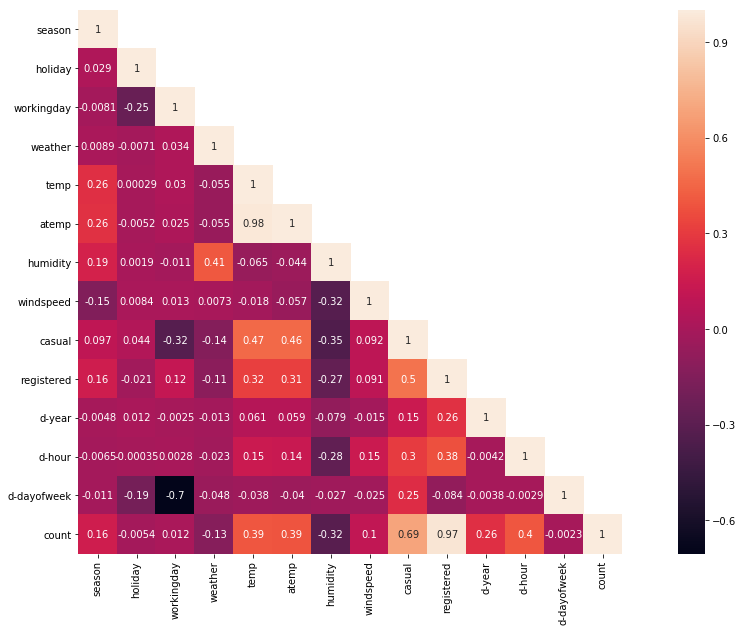

In [19]:
# Feature 추가를 위한 주요 Feature 별 Correlation 확인
corrMask = train[["season", "holiday", "workingday", "weather",            
            "temp", "atemp", "humidity", "windspeed", "casual", "registered",
                 "d-year", "d-hour", "d-dayofweek","count"]].corr()
mask = np.array(corrMask)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMask, mask=mask,vmax=1.0, square=True, annot=True)

# registered, casual과 count의 Correlation이 가장 높음 --> 3개가 관련있는 값으로 추정됨

In [20]:
# 13개 Features 정의
features_13 = ["season", "holiday", "workingday", "weather",            
            "temp", "atemp", "humidity", "windspeed", "casual", "registered",
                 "d-year", "d-hour", "d-dayofweek"]

X13 = train[features_13]

# 13개 Feature를 통해 Train, Test Data Split
np.random.seed(1011)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X13, y, test_size = 0.2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X13, y_log, test_size = 0.2)

model2 = RandomForestRegressor(n_estimators= 100)
model2.fit(X_train2, y_train2)
model3 = RandomForestRegressor(n_estimators= 100)
model3.fit(X_train3, y_train3)
print(f"Feature 13개 모델의 R스퀘어 값(결과값 y): {model2.score(X_test2, y_test2):.5f}")
print(f"Feature 13개 모델의 R스퀘어 값(결과값 y_log): {model3.score(X_test3, y_test3):.5f}")

# --> y_log를 결과 값으로 했을 때 약간의 성능 향상이 있었으며 13개 Features를 input값으로 했을 경우 99% 이상의 R스퀘어를 얻을 수 있었음
# --> casual과 registered 가 큰 영향을 미치는 것으로 보임. --> 영향이 너무 큼. 의심이 필요함

Feature 13개 모델의 R스퀘어 값(결과값 y): 0.99973
Feature 13개 모델의 R스퀘어 값(결과값 y_log): 0.99990


In [21]:
# 2개 Features 정의
features_2 = [ "casual", "registered"]

X2 = train[features_2]

# 2개 Feature를 통해 Train, Test Data Split
np.random.seed(441)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X2, y, test_size = 0.2)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X2, y_log, test_size = 0.2)

model4 = RandomForestRegressor(n_estimators= 100)
model4.fit(X_train4, y_train4)
model5 = RandomForestRegressor(n_estimators= 100)
model5.fit(X_train5, y_train5)
print(f"Feature 2개 모델의 R스퀘어 값(결과값 y): {model4.score(X_test4, y_test4):.5f}")
print(f"Feature 2개 모델의 R스퀘어 값(결과값 y_log): {model5.score(X_test5, y_test5):.5f}")

# --> 해당 2개의 featuress는 count와 같은 y값으로 추정됨.(Lable 값)

Feature 2개 모델의 R스퀘어 값(결과값 y): 0.99980
Feature 2개 모델의 R스퀘어 값(결과값 y_log): 0.99994


In [27]:
# casual과 registered를 제외하고 correlations가 높은 features들로 모델링 진행
# 5개 Features 정의
features_5 = [ "season", "temp", "atemp","d-year","d-hour"]

X5 = train[features_5]

# 5개 Feature를 통해 Train, Test Data Split
np.random.seed(441)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X5, y, test_size = 0.2)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y_log, test_size = 0.2)

model4 = RandomForestRegressor(n_estimators= 100)
model4.fit(X_train4, y_train4)
model5 = RandomForestRegressor(n_estimators= 100)
model5.fit(X_train5, y_train5)
print(f"Feature 5개 모델의 R스퀘어 값(결과값 y): {model4.score(X_test4, y_test4):.5f}")
print(f"Feature 11개 모델의 R스퀘어 값(결과값 y): {model.score(X_test, y_test):.5f}")
print("-------------------------------------------------------------------------")
print(f"Feature 5개 모델의 R스퀘어 값(결과값 y_log): {model5.score(X_test5, y_test5):.5f}")
print(f"Feature 11개 모델의 R스퀘어 값(결과값 y_log): {model1.score(X_test1, y_test1):.5f}")

# --> features 11개의 모델보다 좋은 성능을 발휘하지 못함.

Feature 5개 모델의 R스퀘어 값(결과값 y): 0.68277
Feature 11개 모델의 R스퀘어 값(결과값 y): 0.94932
-------------------------------------------------------------------------
Feature 5개 모델의 R스퀘어 값(결과값 y_log): 0.78853
Feature 11개 모델의 R스퀘어 값(결과값 y_log): 0.95439


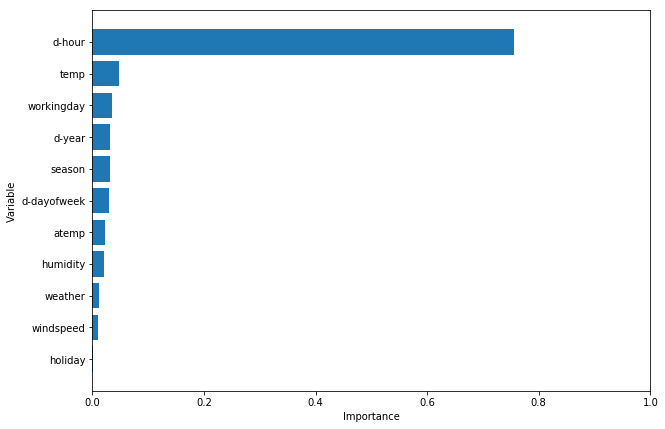

In [28]:
# 11개 feature 주요 특성 검색

df = pd.DataFrame({'feature':features_11,'importance':model1.feature_importances_ })
df=df.sort_values('importance', ascending=True)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

# d-hour가 높은 중요도를 보임 --> Correlation과 동일

In [29]:
# RMSLE function

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [42]:
# 11개 features 사용

from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None

# Initialize regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X_train1, y_train1)

# Make predictions
preds = lModel.predict(X_test1)
print(f"회귀 분석: {lModel.score(X_test1, y_test1)}")
print("회귀 분석 with RMSLE: ",rmsle(np.exp(y_test1),np.exp(preds),False))

# --> RMSLE 기반 LinearRegression 사용 시 모델의 결과값이 훨씬 더 좋아짐

회귀 분석: 0.4811388138755067
회귀 분석 with RMSLE:  0.958243286960859


In [44]:
# 11개 feature 정규화 수행
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_sc = sc.fit_transform(X11)

np.random.seed(1313)
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(x_sc, y_log, test_size = 0.2)

# Train the model
lModel1 = LinearRegression()
lModel1.fit(X_train_sc, y_train_sc)
model_rf = RandomForestRegressor(n_estimators= 100)
model_rf.fit(X_train_sc, y_train_sc)

# Make predictions
preds1 = lModel1.predict(X_test_sc)
print("회귀 분석 with RMSLE, with scaling data: ",rmsle(np.exp(y_test_sc),np.exp(preds1),False))
print("회귀 분석 with RMSLE, with non-scaling data: ",rmsle(np.exp(y_test1),np.exp(preds),False))
print("--------------------------------------------------------------------------------------")
print(f"랜덤포레스트 회귀 with scaling data: {model_rf.score(X_test_sc, y_test_sc)}")
print(f"랜덤포레스트 회귀 with non-scaling data: {model1.score(X_test1, y_test1)}")

# 회귀분석 --> Features들을 정규화 했을 시 모델의 정확도가 더욱 높아짐.
# 랜덤포레스트 회귀 --> 기존 정확도보다 떨어졌음 (기존: Feature 11개 모델의 R스퀘어 값(결과값 y_log): 0.95439)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


회귀 분석 with RMSLE, with scaling data:  0.980529938207511
회귀 분석 with RMSLE, with non-scaling data:  0.958243286960859
--------------------------------------------------------------------------------------
랜덤포레스트 회귀 with scaling data: 0.9495222956149686
랜덤포레스트 회귀 with non-scaling data: 0.9543896912684404


## 모델 구성에 영향을 주는 요소
1. Feature --> y 값과 상관관계가 큰 feature 선택이 중요.
2. 모델 --> randomforest가 기본적으로 좋은 성능을 내지만, feature 및 패널티 튜닝이 잘 되면 선형 회귀도 좋은 성능을 냄. 상황에 따라 다름
3. 정규화 --> 회귀 모델의 경우는 특히 정규화가 필수적. 정규화를 통해 편차를 줄이는 것이 모델 성능 향상에 중요함 
4. 패널티(-> 이번 케이스에는 과소평가 된 항목에 패널티를 주는게 모델 성능에 더 좋았음.)